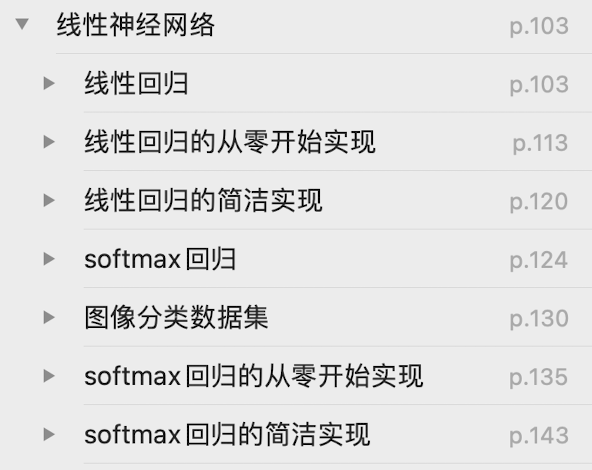


今天240125开始
# 3.1.2 矢量化加速

In [11]:
import math
import time
import numpy as np
import torch
from d2l import torch as d2l
from matplotlib import pyplot as plt

In [3]:
n=10000
a=torch.ones([n])
b=torch.ones([n])

In [4]:
class Timer:
    # 记录运行时间
    def __init__(self) -> None:
        self.times=[]
        self.start()
    def start(self):
        # 启动计时器
        self.tik = time.time()
    def stop(self):
        # 停止计时器并将时间记录在列表中
        self.times.append(time.time()-self.tik)
        return self.times[-1]
    def avg(self):
        # 返回平均时间
        return sum(self.times)/len(self.times)
    def sum(self):
        # 返回时间总和
        return sum(self.times)
    def cumsum(self):
        # 返回累计时间
        return np.array(self.times).cumsum().tolist()


In [5]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i]=a[i]+b[i]
print(f'{timer.stop():.5f} sec')

0.05649 sec


In [6]:
timer.start()
d = a + b
print(f'{timer.stop():.5f} sec')

0.00025 sec


# 管理环境

- conda create -n pytorch python=3.6 
- -n表示name名字的意思 名字是pytorch
- 需要的依赖项 python版本是3.6
- 激活环境 conda activate pytorch(左边括号)
- 关闭环境 conda deactiavte
- pip list 查看工具包

# 安装pytorch

1. 进入pytorch首页
2. 选择自己电脑适配的 win下选择conda linux下选择pip
   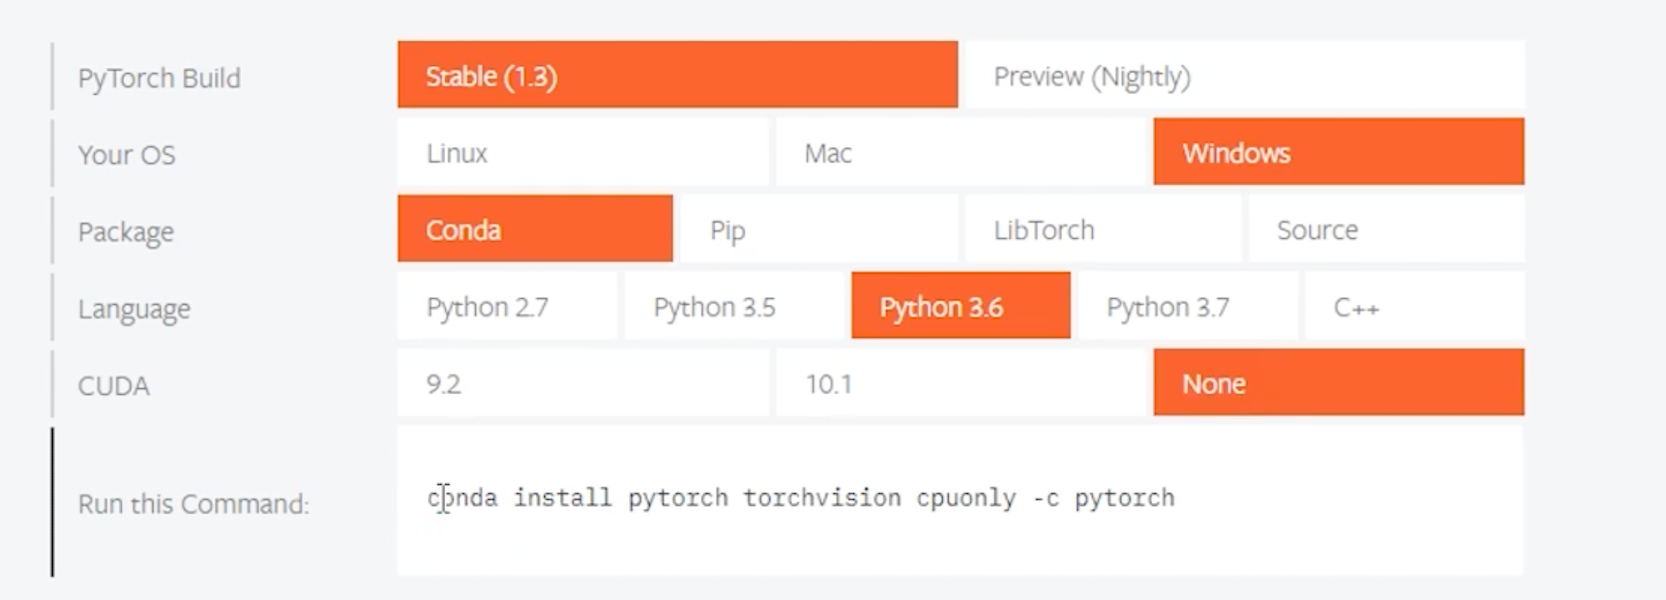
3. 然后在anaconda的prompt下运行命令

# 3.1.3 正态分布与平方损失

In [9]:
def normal(x,mu,sigma):
    p = 1/math.sqrt(2*math.pi*sigma**2)
    return p*np.exp(-0.5 / sigma**2 * (x-mu)**2)

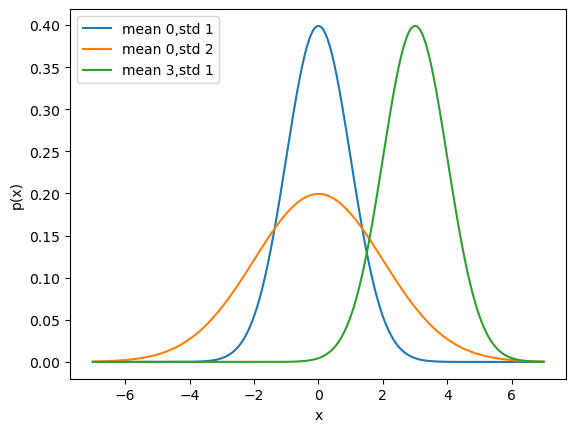

In [21]:
x = np.arange(-7,7,0.01)
params = [(0,1),(0,2),(3,1)]
plt.plot(x,normal(x,0,1))
plt.plot(x,normal(x,0,2))
plt.plot(x,normal(x,3,1))
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend([f'mean {mu},std {sigma}' for mu,sigma in params])
plt.show()
# d2l.plot(x,[normal(x,mu,sigma) for mu,sigma in params],
#          xlabel='x',
#          ylabel='p(x)', 
#          figsize=(4.5,2.5),
#          legend=[f'mean {mu},std {sigma}' for mu,sigma in params])

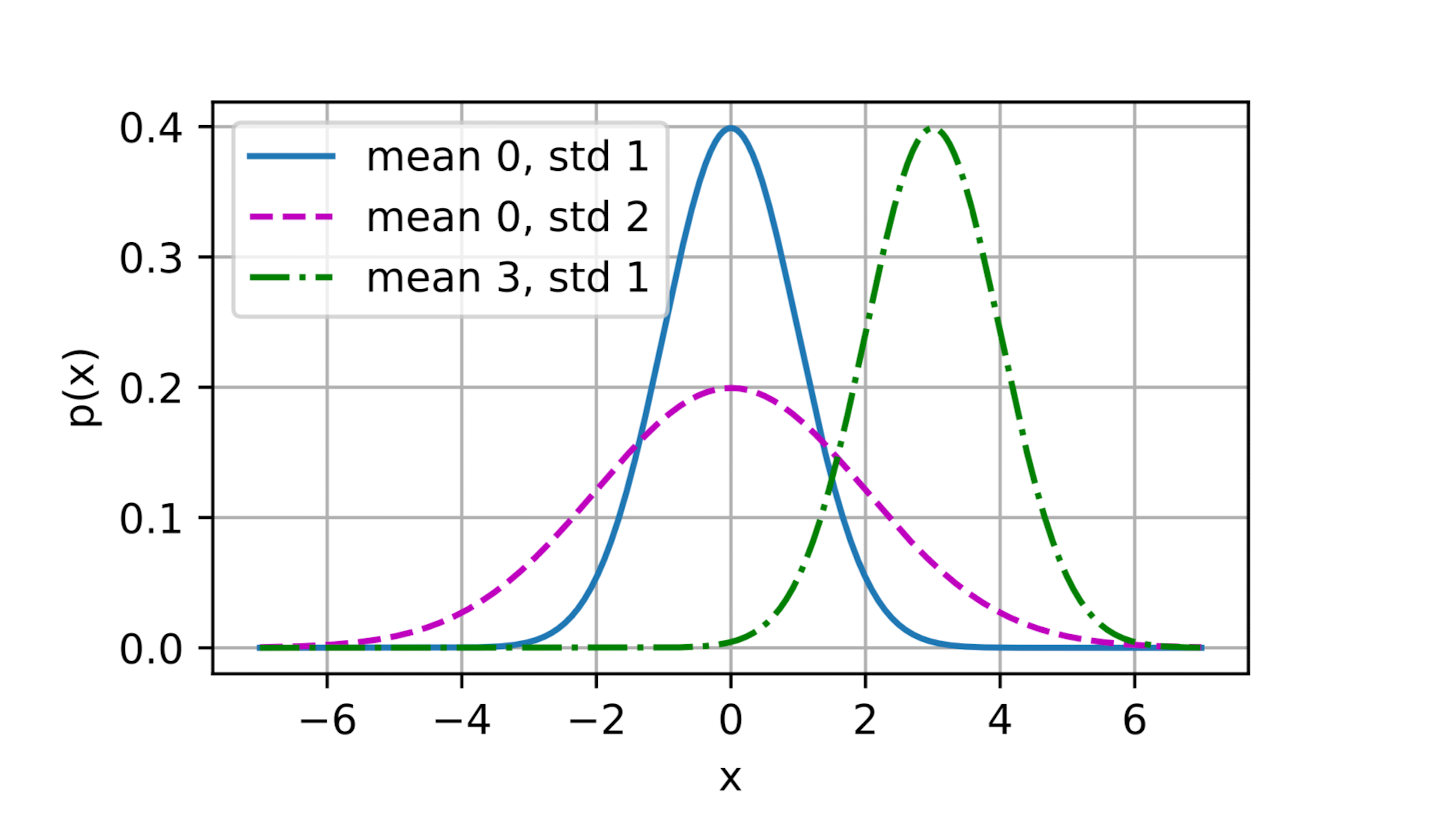

# 3.2 线性回归的从零开始实现

In [22]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [23]:
def synthetic_data(w,b,num_examples):
    X = torch.normal(0,1,(num_examples,len(w))) # 均值0 方差1 还有size
    y = torch.matmul(X,w)+b 
    y += torch.normal(0,0.01,y.shape) #加噪声
    return X,y.reshape((-1,1))

In [24]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = synthetic_data(true_w,true_b,1000)
print('features:',features[0],'\n label:',labels[0]) # features = samples

features: tensor([-0.3008,  1.1847]) 
 label: tensor([-0.4255])


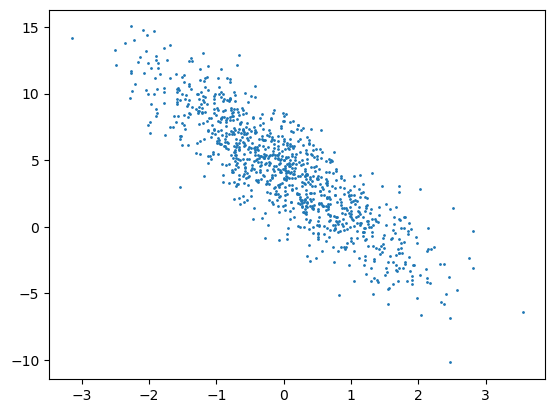

In [28]:
# plt.set_figsize()
plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1)

In [29]:
def data_iter(batch_size,samples,labels):
    num_examples=len(samples)
    indices=list(range(num_examples))
    # 这些样本是随机读取的，没有特定顺序
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size,num_examples)]
        )
    yield samples[batch_indices],labels[batch_indices]

In [30]:
batch_size=10
for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break

tensor([[ 2.1071,  0.2913],
        [ 2.1281,  0.1400],
        [-0.7094, -0.2951],
        [ 0.6658, -0.3281],
        [ 0.1184, -0.0710],
        [ 0.7580,  0.2871],
        [-0.6977, -1.6273],
        [ 0.3882,  0.7653],
        [ 0.6351, -2.0130],
        [ 1.5658, -2.2671]]) 
 tensor([[ 7.4287],
        [ 7.9785],
        [ 3.7800],
        [ 6.6252],
        [ 4.6812],
        [ 4.7471],
        [ 8.3361],
        [ 2.3761],
        [12.3080],
        [15.0444]])


In [31]:
w = torch.normal(0,0.01,size=(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

In [32]:
def linreg(X,w,b):
    return torch.matmul(X,w)+b

In [33]:
def squared_loss(y_hat,y):
    return (y_hat - y.reshape(y_hat.shape))**2 /2

In [34]:
def sgd(params,lr,batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [49]:
lr = 0.02
num_epochs = 3
net = linreg
loss = squared_loss

In [50]:
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b),y)
        l.sum().backward()
        sgd([w,b],lr,batch_size)
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch {epoch+1},loss {float(train_l.mean()):f}')

epoch 1,loss 0.000050
epoch 2,loss 0.000050
epoch 3,loss 0.000050


In [51]:
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([-0.0003, -0.0006], grad_fn=<SubBackward0>)
b的估计误差：tensor([-0.0002], grad_fn=<RsubBackward1>)


# 3.3.1 生成数据集

In [52]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [54]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = synthetic_data(true_w,true_b,1000)

In [55]:
def load_array(data_arrays,batch_size,is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset,batch_size,shuffle=is_train)

batch_size = 10
data_iter = load_array((features,labels),batch_size)

In [57]:
# iter构造python迭代器 next从迭代器中获取第一项
next(iter(data_iter))

[tensor([[ 0.0417,  0.6360],
         [-1.3048,  0.9115],
         [-0.0331,  0.2093],
         [-0.2503, -0.5964],
         [-0.4978, -0.9779],
         [ 0.1844,  1.0901],
         [ 1.8677, -0.0547],
         [-2.1887,  1.0233],
         [ 0.3387,  0.3516],
         [ 0.6330,  1.8760]]),
 tensor([[ 2.1340],
         [-1.5175],
         [ 3.4260],
         [ 5.7295],
         [ 6.5282],
         [ 0.8534],
         [ 8.1364],
         [-3.6447],
         [ 3.6966],
         [-0.9011]])]

In [58]:
from torch import nn

In [59]:
net = nn.Sequential(nn.Linear(2,1))

In [62]:
# net[0].weight.data 获取数据
# net[0].weight.data.normal_ 重写数据
net[0].weight.data.normal_(0,0.01),net[0].bias.data.fill_(0)

(tensor([[ 0.0150, -0.0030]]), tensor([0.]))

In [63]:
loss = nn.MSELoss()

In [64]:
trainer = torch.optim.SGD(net.parameters(),lr=0.03)

In [69]:
num_epochs = 3
for epoch in range(num_epochs):
    for X,y in data_iter:
       l = loss(net(X),y) 
       trainer.zero_grad()
       l.backward()
       trainer.step()
    l = loss(net(features),labels)
    print(f'epoch {epoch+1},loss {l:f}') 

epoch 1,loss 0.000107
epoch 2,loss 0.000106
epoch 3,loss 0.000108


In [74]:
w = net[0].weight.data
print('w的估计误差：',true_w - w)
b = net[0].bias.data
print('b的估计误差：',true_b - b)

w的估计误差： tensor([[-5.0354e-04, -6.7234e-05]])
b的估计误差： tensor([0.0015])


In [73]:
true_w-w

tensor([[-5.0354e-04, -6.7234e-05]])

# 3.5 图像分类数据集

In [75]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

In [76]:
d2l.use_svg_display()

AttributeError: module 'torch' has no attribute 'use_svg_display'

## 3.5.1 读取数据集

In [77]:
# 通过ToTensorFlow实例将图像数据从PIL类型变换为32位浮点数格式
# 并除以255使得所有像素的数值均在0~1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root='../data',train=True,transform=trans,download=True
)
mnist_test = torchvision.datasets.FashionMNIST(
    root='../data',train=False,transform=trans,download=True
)

100%|██████████| 26421880/26421880 [01:20<00:00, 327359.48it/s] 


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 180904.68it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:09<00:00, 457420.00it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12776495.26it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [78]:
len(mnist_train),len(mnist_test),mnist_train[0][0].shape

(60000, 10000, torch.Size([1, 28, 28]))

In [79]:
def get_fashion_mnist_label(labels):
    text_labels = ['t-shirt','trouser','pullover','dress','coat',
                   'sandal','shirt','sneaker','bag','ankle boot']
    return [text_labels[int(i)] for i in labels]

In [82]:
def show_images(imgs,num_rows,num_cols,titles=None,scale=1.5):
    figsize = (num_cols * scale , num_rows * scale)
    _,axes = plt.subplots(num_rows,num_cols,figsize=figsize)
    axes = axes.flatten()
    for i,(ax,img) in enumerate(zip(axes,imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

array([<Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'dress'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 't-shirt'}>], dtype=object)

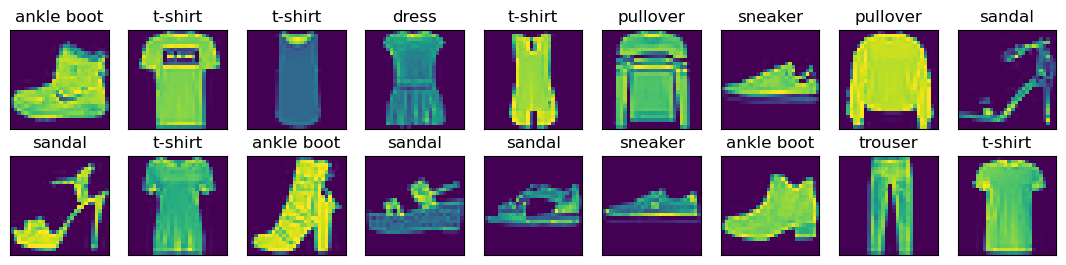

In [83]:
X,y = next(iter(data.DataLoader(mnist_train,batch_size=18)))
show_images(X.reshape(18,28,28),2,9,titles=get_fashion_mnist_label(y))

In [87]:
batch_size = 256

def get_dataloader_workers():
    return 4

train_iter = data.DataLoader(mnist_train,batch_size,shuffle=True,
                             num_workers=get_dataloader_workers())

In [92]:
timer = Timer()
for X,y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'2.50 sec'

In [91]:
dir(d2l)

['AVG',
 'AggregationType',
 'AliasDb',
 'Any',
 'AnyType',
 'Argument',
 'ArgumentSpec',
 'AwaitType',
 'BFloat16Storage',
 'BFloat16Tensor',
 'BenchmarkConfig',
 'BenchmarkExecutionStats',
 'Block',
 'BoolStorage',
 'BoolTensor',
 'BoolType',
 'BufferDict',
 'ByteStorage',
 'ByteTensor',
 'CallStack',
 'Callable',
 'Capsule',
 'CharStorage',
 'CharTensor',
 'ClassType',
 'Code',
 'CompilationUnit',
 'CompleteArgumentSpec',
 'ComplexDoubleStorage',
 'ComplexFloatStorage',
 'ComplexType',
 'ConcreteModuleType',
 'ConcreteModuleTypeBuilder',
 'DeepCopyMemoTable',
 'DeserializationStorageContext',
 'DeviceObjType',
 'Dict',
 'DictType',
 'DisableTorchFunction',
 'DisableTorchFunctionSubclass',
 'DispatchKey',
 'DispatchKeySet',
 'DoubleStorage',
 'DoubleTensor',
 'EnumType',
 'ErrorReport',
 'ExcludeDispatchKeyGuard',
 'ExecutionPlan',
 'FatalError',
 'FileCheck',
 'FloatStorage',
 'FloatTensor',
 'FloatType',
 'FunctionSchema',
 'Future',
 'FutureType',
 'Generator',
 'Gradient',
 'Grap